In [2]:
import tweepy 
import configparser
import requests     # For saving access tokens and for file management when creating and adding to the dataset
import os           # For dealing with json responses we receive from the API
import json         # For displaying the data after
import pandas as pd # For saving the response data in CSV format
import csv          # For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata  #To add wait time between requests
import time
import sqlite3
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Read Configs

The following code reads configuration values from a `config.ini` file.

#### Usage

1. Ensure you have a `config.ini` file with the required values.
2. Replace the placeholders with your actual configuration values.
3. Run the code to read the configuration.

#### Example `config.ini` File

```ini
[twitter]
api_key = YOUR_API_KEY
api_key_secret = YOUR_API_KEY_SECRET
access_token = YOUR_ACCESS_TOKEN
access_token_secret = YOUR_ACCESS_TOKEN_SECRET
bearer_token = YOUR_BEARER_TOKEN

In [3]:
"""Read configuration values from the 'config.ini' file.
    
    Returns:
        api_key (str): The API key for Twitter.
        api_key_secret (str): The API key secret for Twitter.
        access_token (str): The access token for Twitter.
        access_token_secret (str): The access token secret for Twitter.
        bearer_token (str): The bearer token for Twitter.
"""

config = configparser.ConfigParser()
config.read('config.ini')

api_key             = config['twitter']['api_key']
api_key_secret      = config['twitter']['api_key_secret']

access_token        = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

bearer_token        = config['twitter']['bearer_token']

### Authenticate with the Twitter API

The following code authenticates your account with the Twitter API using the provided credentials.

### Usage

1. Replace the placeholders (`api_key`, `api_key_secret`, `access_token`, `access_token_secret`, `bearer_token`) with your actual Twitter API credentials.
2. Run the code to authenticate your account and print the screen name/username of the authenticated account.


In [4]:
def authenticate_twitter_api(api_key, api_key_secret, access_token, access_token_secret, bearer_token):
    """
    Authenticate with the Twitter API using the provided credentials.

    Args:
        api_key (str): The API key for Twitter.
        api_key_secret (str): The API key secret for Twitter.
        access_token (str): The access token for Twitter.
        access_token_secret (str): The access token secret for Twitter.
        bearer_token (str): The bearer token for Twitter.

    Returns:
        str: The screen name/username of the authenticated account.
    """
    auth = tweepy.OAuthHandler(api_key, api_key_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)

    client = tweepy.Client(bearer_token=bearer_token)

    screen_name = api.verify_credentials().screen_name
    print(screen_name)
    return client

client = authenticate_twitter_api(api_key, api_key_secret, access_token, access_token_secret, bearer_token)

KLuthra_


## Set up SQLite database

The following code sets up an SQLite database and creates two tables: `tweets` and `users`.


In [4]:
# Set up SQLite database
conn = sqlite3.connect('twitter_data.db')
c = conn.cursor()

In [5]:
# Create table for tweet data
c.execute('''CREATE TABLE IF NOT EXISTS tweets
             (tweet_id INTEGER PRIMARY KEY,
              author_id INTEGER,
              created_at TIMESTAMP,
              text TEXT,
              tweet_metrics JSON,
              entities JSON,
              context JSON,
              place_id JSON,
              FOREIGN KEY (author_id) REFERENCES users(author_id),
              FOREIGN KEY (place_id) REFERENCES users(place_id))''')

In [6]:
# Create table for user data
c.execute('''CREATE TABLE IF NOT EXISTS users
             (author_id INTEGER PRIMARY KEY,
              username TEXT,
              verified TEXT,
              bio TEXT,
              author_created TIMESTAMP,
              author_location TEXT,
              followers_count INTEGER,
              following_count INTEGER,
              tweet_count INTEGER,
              entities JSON,
              FOREIGN KEY (author_id) REFERENCES tweets(author_id))''')

In [7]:
c.execute("PRAGMA table_info(tweets)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT tweet_id) FROM tweets")
row_count = c.fetchone()[0]
print(f"Number of rows in 'tweets' table: {row_count}\n")


c.execute("PRAGMA table_info(users)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT author_id) FROM users")
row_count = c.fetchone()[0]
print(f"Number of rows in 'users' table: {row_count}\n")

tweet_id - INTEGER
author_id - INTEGER
created_at - TIMESTAMP
text - TEXT
tweet_metrics - JSON
entities - JSON
context - JSON
place_id - JSON
Number of rows in 'tweets' table: 36370

author_id - INTEGER
username - TEXT
verified - TEXT
bio - TEXT
author_created - TIMESTAMP
author_location - TEXT
followers_count - INTEGER
following_count - INTEGER
tweet_count - INTEGER
entities - JSON
Number of rows in 'users' table: 0



## DATA EXTRACTION

### Function: get_tweets

**Description:**
Fetches recent tweets from the Twitter API based on a given query.

**Parameters:**
- query (str): The query string to search for tweets.
- max_results (int): The maximum number of tweets to fetch.

**Returns:**
- List of tweets (objects): A list of fetched tweets matching the query.

**Raises:**
- Exception: If there is an error while fetching tweets.


In [ ]:
def get_tweets(query, max_results):
  """
    Fetches recent tweets from the Twitter API based on a given query.

    Parameters:
        query (str): The query string to search for tweets.
        max_results (int): The maximum number of tweets to fetch.

    Returns:
        List of tweets (objects): A list of fetched tweets matching the query.

    Raises:
        Exception: If there is an error while fetching tweets.
  """
  expansions    = ['author_id','in_reply_to_user_id','geo.place_id','entities.mentions.username','referenced_tweets.id','referenced_tweets.id.author_id']
  tweet_fields  = ['id','text','author_id','attachments','context_annotations','created_at','entities','lang','geo','public_metrics']
  user_fields   = ['id','name','username','created_at','description','entities','location','public_metrics','verified']
  place_fields  = ['full_name','id','country','country_code','geo','name','place_type']
  try:
    # call twitter api to fetch tweets
    fetched_tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
      expansions        =expansions,
      tweet_fields      =tweet_fields,
      place_fields      =place_fields,
      user_fields       =user_fields,   
      max_results       =max_results
    ).flatten()
    
    return fetched_tweets
    

  except Exception as e:
    print("Error getting tweets", e)

### Function: automate_domain_filter

**Description:**
Automates the process of creating chunks of query strings for domain filtering based on the provided DataFrame.

**Parameters:**
- df (DataFrame): The DataFrame containing the domain information.
- start_id (int): The starting domain ID.
- end_id (int): The ending domain ID.
- chunk_size (int): The maximum size of each chunk in characters.
- domain_chunk_count (dict): A dictionary specifying the number of chunks for each domain ID.

**Returns:**
- List of chunks (list): A list of query string chunks.


In [ ]:
domain_df = pd.read_csv('twitter-context-annotations/files/evergreen-context-entities-20220601.csv')
import itertools
def automate_domain_filter(df, start_id, end_id, chunk_size, domain_chunk_count):
    """
    Automates the process of creating chunks of query strings for domain filtering based on the provided DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the domain information.
        start_id (int): The starting domain ID.
        end_id (int): The ending domain ID.
        chunk_size (int): The maximum size of each chunk in characters.
        domain_chunk_count (dict): A dictionary specifying the number of chunks for each domain ID.

    Returns:
        List of chunks (list): A list of query string chunks.
    """
    chunks_list = []
    for i in range(start_id, end_id+1):
        context_list = []
        mask = df['domains'].str.contains('^{}$'.format(i))
        filtered_df = df[mask]
        for index, row in filtered_df.iterrows():
            domain_id = row['domains']
            entity_id = row['entity_id']
            entity_name = row['entity_name']   
            # construct the query string
            context = f'context:{domain_id}.{entity_id}'
            context_list.append(context)
            context_query = ' OR '.join(context_list)
        code = context_query
        chunks = []
        start = 0
        counter = 0
        while start < len(code) and counter < domain_chunk_count[i]:
            end = start + chunk_size
            if end >= len(code):
                end = len(code)
            end = code.rfind(" OR ", start, end)
            if end == -1:
                end = start + chunk_size
            chunk = code[start:end]
            if chunk.startswith(" OR "):
                chunk = chunk[4:]
            chunks.append(chunk)
            start = end
            counter += 1
        chunks_list.append(chunks)
    return list(itertools.chain.from_iterable(chunks_list))

chunk_size = 350
domain_chunk_count = {45: 1, 46: 6, 47: 276, 48: 69}
chunks_list = automate_domain_filter(domain_df, 45, 48, chunk_size, domain_chunk_count)

### Function: filter_rule

**Description:**
Creates a query string for filtering tweets based on the provided chunk.

**Parameters:**
- chunk (str): The chunk representing a portion of the query string.
- hash_include (bool): Flag indicating whether to include hashtag-related filter rules. Default is True.

**Returns:**
- query (str): The constructed query string.

In [ ]:
def filter_rule(chunk, hash_include=True):
    """
    Creates a query string for filtering tweets based on the provided chunk.

    Parameters:
        chunk (str): The chunk representing a portion of the query string.
        hash_include (bool): Flag indicating whether to include hashtag-related filter rules. Default is True.

    Returns:
        query (str): The constructed query string.
    """
    text_list       = '(#ad OR #sponsored OR #promoted OR "Learn More" OR "Shop Now")'
    lang            = '(lang:en)'
    rt              = '(-is:retweet) (-"RT")' 
    domain            = chunk
    mention         = 'has:mentions'
    if hash_include == True:
        query           = text_list + ' ' + lang + ' ' + rt + ' ' + mention + ' ' + '(' + domain + ')'
    else: 
        query           = lang + ' ' + rt + ' ' + mention + ' ' + '(' + domain + ')'

    return query

The following code retrieves tweets using the generated chunks and stores the tweet data in a list called `tweet_data`. It iterates over each chunk, applies the filter rule, and retrieves tweets using the `get_tweets` function. The retrieved tweet information is then appended to the `tweet_data` list.


In [ ]:
import time
import tweepy
import pandas as pd

processed_tweets = 0
total_tweets = 0

tweet_data = []  # List to store tweet data

for chunk in chunks_list:
    print(f'Chunk: {chunk}')
    
    query = filter_rule(chunk=chunk,hash_include=True)
    paginator = get_tweets(query=query, max_results=100)

    if paginator is None:
        print('Error: Paginator is None. Skipping chunk.')
        continue
    
    for tweet in paginator:
        tweet_info = {
                'tweet_id': tweet.id,
                'author_id': tweet.author_id,
                'created_at': tweet.created_at,
                'text': tweet.text,
                'tweet_metrics': json.dumps(tweet.public_metrics),
                'entities': json.dumps(tweet.entities),
                'context': json.dumps(tweet.context_annotations),
                'place_id': json.dumps(tweet.geo) if tweet.geo else None
            }
            
        tweet_data.append(tweet_info)
        processed_tweets += 1
    
    
    print(f'Finished processing chunk: {chunk}')
    print(f'Progress: {processed_tweets} tweets processed.')
    time.sleep(3)  # Pause for 5 minutes between chunks to avoid hitting rate limits


The code snippet converts the `tweet_data` list into a DataFrame called `df`. It then sorts the DataFrame in ascending order based on the 'tweet_id' column. Next, it drops duplicate rows based on the 'tweet_id' column, keeping only the last occurrence of each tweet. The resulting DataFrame is stored in the `dedup_df` variable.


In [ ]:
# Convert tweet_data list to a DataFrame
df = pd.DataFrame(tweet_data)

# Sort the DataFrame by 'tweet_id' in descending order
df.sort_values('tweet_id', ascending=True, inplace=True)

# Drop duplicate rows based on 'tweet_id' column, keeping the last occurrence
dedup_df = df.drop_duplicates(subset='tweet_id', keep='last', inplace=False).reset_index(drop=True, inplace=False)

print(dedup_df.shape)

### Function process_tweets_to_database

The code snippet defines a function `process_tweets_to_database` that processes tweets from a DataFrame and inserts or updates them in a SQLite database.

In [ ]:
def process_tweets_to_database(df, conn, c):
    """
    Processes tweets from a DataFrame and inserts or updates them in a SQLite database.

    Args:
        df (pandas.DataFrame): DataFrame containing tweet data.
        conn (sqlite3.Connection): SQLite database connection.
        c (sqlite3.Cursor): SQLite database cursor.

    Returns:
        int: Number of tweets processed.

    """
    processed_tweets = 0

    for index, tweet in df.iterrows():
        try:
            created_at = tweet['created_at'].strftime('%Y-%m-%d %H:%M:%S')
            # Check if tweet with the same tweet_id already exists in the database
            c.execute('SELECT tweet_id FROM tweets WHERE tweet_id=?', (tweet['tweet_id'],))
            existing_tweet_id = c.fetchone()

            if existing_tweet_id is None:
                # Tweet doesn't exist in the database, insert it
                c.execute('''INSERT INTO tweets 
                             (tweet_id, author_id, created_at, text, tweet_metrics, entities, context, place_id) 
                             VALUES (?, ?, ?, ?, ?, ?, ?, ?)''',
                          (tweet['tweet_id'], tweet['author_id'], created_at, tweet['text'],
                           tweet['tweet_metrics'], tweet['entities'], tweet['context'], tweet['place_id']))
                print("New Tweet Appended")
            else:
                # Tweet already exists, update tweet_metrics
                c.execute('''UPDATE tweets 
                             SET tweet_metrics = ? 
                             WHERE tweet_id = ?''',
                          (tweet['tweet_metrics'], tweet['tweet_id']))
                print("Tweet Already Exists, Updating Tweet Metrics")
            processed_tweets += 1

            print(f'Progress: {processed_tweets} tweets processed.')

        except Exception as e:
            print(f"Error inserting row: {tweet}")
            print(f"Error message: {e}")

    # Commit the changes and close the connection
    conn.commit()

    return processed_tweets

process_tweets_to_database(df=dedup_df, conn=conn, c=c)


In [ ]:
# Get unique author IDs from the tweets table
c.execute("SELECT DISTINCT author_id FROM tweets")
author_ids = [row[0] for row in c.fetchall()]

user_data = []
batch_size = 100
n = 0

# Iterate over batches of author IDs
for i in range(0, len(author_ids), batch_size):      
    # try:
    users = client.get_users(ids=author_ids[i:i+batch_size], user_fields=['id', 'name', 'username', 'created_at', 'description', 'entities', 'location', 'public_metrics', 'verified'])

    # Insert or update the user data in the database
    for user in users.data:
        # Check if author already exists in the database
        c.execute("SELECT author_id FROM users WHERE author_id=?", (user.id,))
        existing_author_id = c.fetchone()

        if existing_author_id is None:
            # Author doesn't exist in the database, insert a new row
            author_created = user.created_at.strftime('%Y-%m-%d %H:%M:%S')
            c.execute('''INSERT INTO users (author_id, username, verified, bio, author_created, author_location, 
                         followers_count, following_count, tweet_count, entities)
                         VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                      (user.id, user.username, user.verified, user.description, author_created,
                       user.location, user.public_metrics['followers_count'], user.public_metrics['following_count'],
                       user.public_metrics['tweet_count'], json.dumps(user.entities)))
            print(f"Stored author: {user.name} (@{user.username}), id={user.id}")
        else:
            # Author already exists in the database, update the existing row
            author_created = user.created_at.strftime('%Y-%m-%d %H:%M:%S')
            c.execute('''UPDATE users SET username=?, verified=?, bio=?, author_created=?, author_location=?, 
                         followers_count=?, following_count=?, tweet_count=?, entities=?
                         WHERE author_id=?''',
                      (user.username, user.verified, user.description, author_created,
                       user.location, user.public_metrics['followers_count'], user.public_metrics['following_count'],
                       user.public_metrics['tweet_count'], json.dumps(user.entities), user.id))
            print(f"Updated author: {user.name} (@{user.username}), id={user.id}")

    time.sleep(16)

### Retrieve Data from SQLite Database

The following code retrieves data from the SQLite database and creates Pandas DataFrames: `tweets_df` and `users_df`.


In [8]:
# Retrieve the data from the SQLite database
query = "SELECT * FROM tweets"
tweets_df = pd.read_sql_query(query, conn, parse_dates=['created_at'])
print(tweets_df.dtypes)


# Retrieve the data from the SQLite database
query = "SELECT * FROM users"
users_df = pd.read_sql_query(query, conn, parse_dates=['author_created'])
print(users_df.dtypes)

tweet_id                  int64
author_id                 int64
created_at       datetime64[ns]
text                     object
tweet_metrics            object
entities                 object
context                  object
place_id                 object
dtype: object
author_id                  object
username                   object
verified                   object
bio                        object
author_created     datetime64[ns]
author_location            object
followers_count            object
following_count            object
tweet_count                object
entities                   object
dtype: object


## Exploratory Data Analysis

### Data Aggregation and DataFrame Creation

The following code aggregates data based on domain ID and creates a new DataFrame from the selected columns of the original tweets DataFrame.


In [18]:
import pandas as pd
import json

def aggregate_data(df):
    """
    Aggregate data based on domain ID from the provided tweets DataFrame.

    Args:
        tweets_df (pd.DataFrame): DataFrame containing tweet data.

    Returns:
        pd.DataFrame: DataFrame with aggregated data based on domain ID.
    """
    subset_df = df[['tweet_id', 'author_id', 'tweet_metrics', 'context', 'entities']]

    subset_context_items = []
    for index, row in subset_df.iterrows():
        context_list = json.loads(row['context'])
        tweet_id     = row['tweet_id']
        author_id    = row['author_id']
        for item in context_list:
            domain_id   = item['domain']['id']
            domain_name = item['domain']['name']
            entity_id   = item['entity']['id']
            entity_name = item['entity']['name']
            data = {'tweet_id': tweet_id, 'author_id': author_id, 'domain_id':domain_id, 'domain_name': domain_name, 'entity_id':entity_id, 'entity_name': entity_name}
            subset_context_items.append(data)

    subset_context_item_df = pd.DataFrame(subset_context_items)
    return subset_context_item_df

subset_context_item_df = aggregate_data(df=tweets_df)

In [20]:
def calculate_top_counts(data_frame, group_by_cols, aggregate_col, top_n):
    """
    Calculate the top counts based on the given DataFrame, group by columns, aggregate column, and number of top counts to retrieve.
    
    Parameters:
        data_frame (pandas.DataFrame): DataFrame containing the data to perform calculations on.
        group_by_cols (list): List of columns to group by.
        aggregate_col (str): Column to perform aggregation on.
        top_n (int): Number of top counts to retrieve.
        
    Returns:
        pandas.DataFrame: Top counts, sorted in descending order.
    """
    subset_agg = data_frame.groupby(by=group_by_cols).agg({aggregate_col: pd.Series.nunique}).reset_index().sort_values(by=aggregate_col, ascending=False)
    top_counts = subset_agg.head(top_n)
    
    return top_counts

top_20_domain_counts = calculate_top_counts(subset_context_item_df, ["domain_name"], "tweet_id", 20)
top_50_entity_counts = calculate_top_counts(subset_context_item_df, ["entity_name"], "tweet_id", 50)
top_25_user_counts = calculate_top_counts(subset_context_item_df, ["author_id"], "tweet_id", 25)

<ipython-input-16-f4fdfd5b349c>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)
<ipython-input-16-f4fdfd5b349c>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=60)


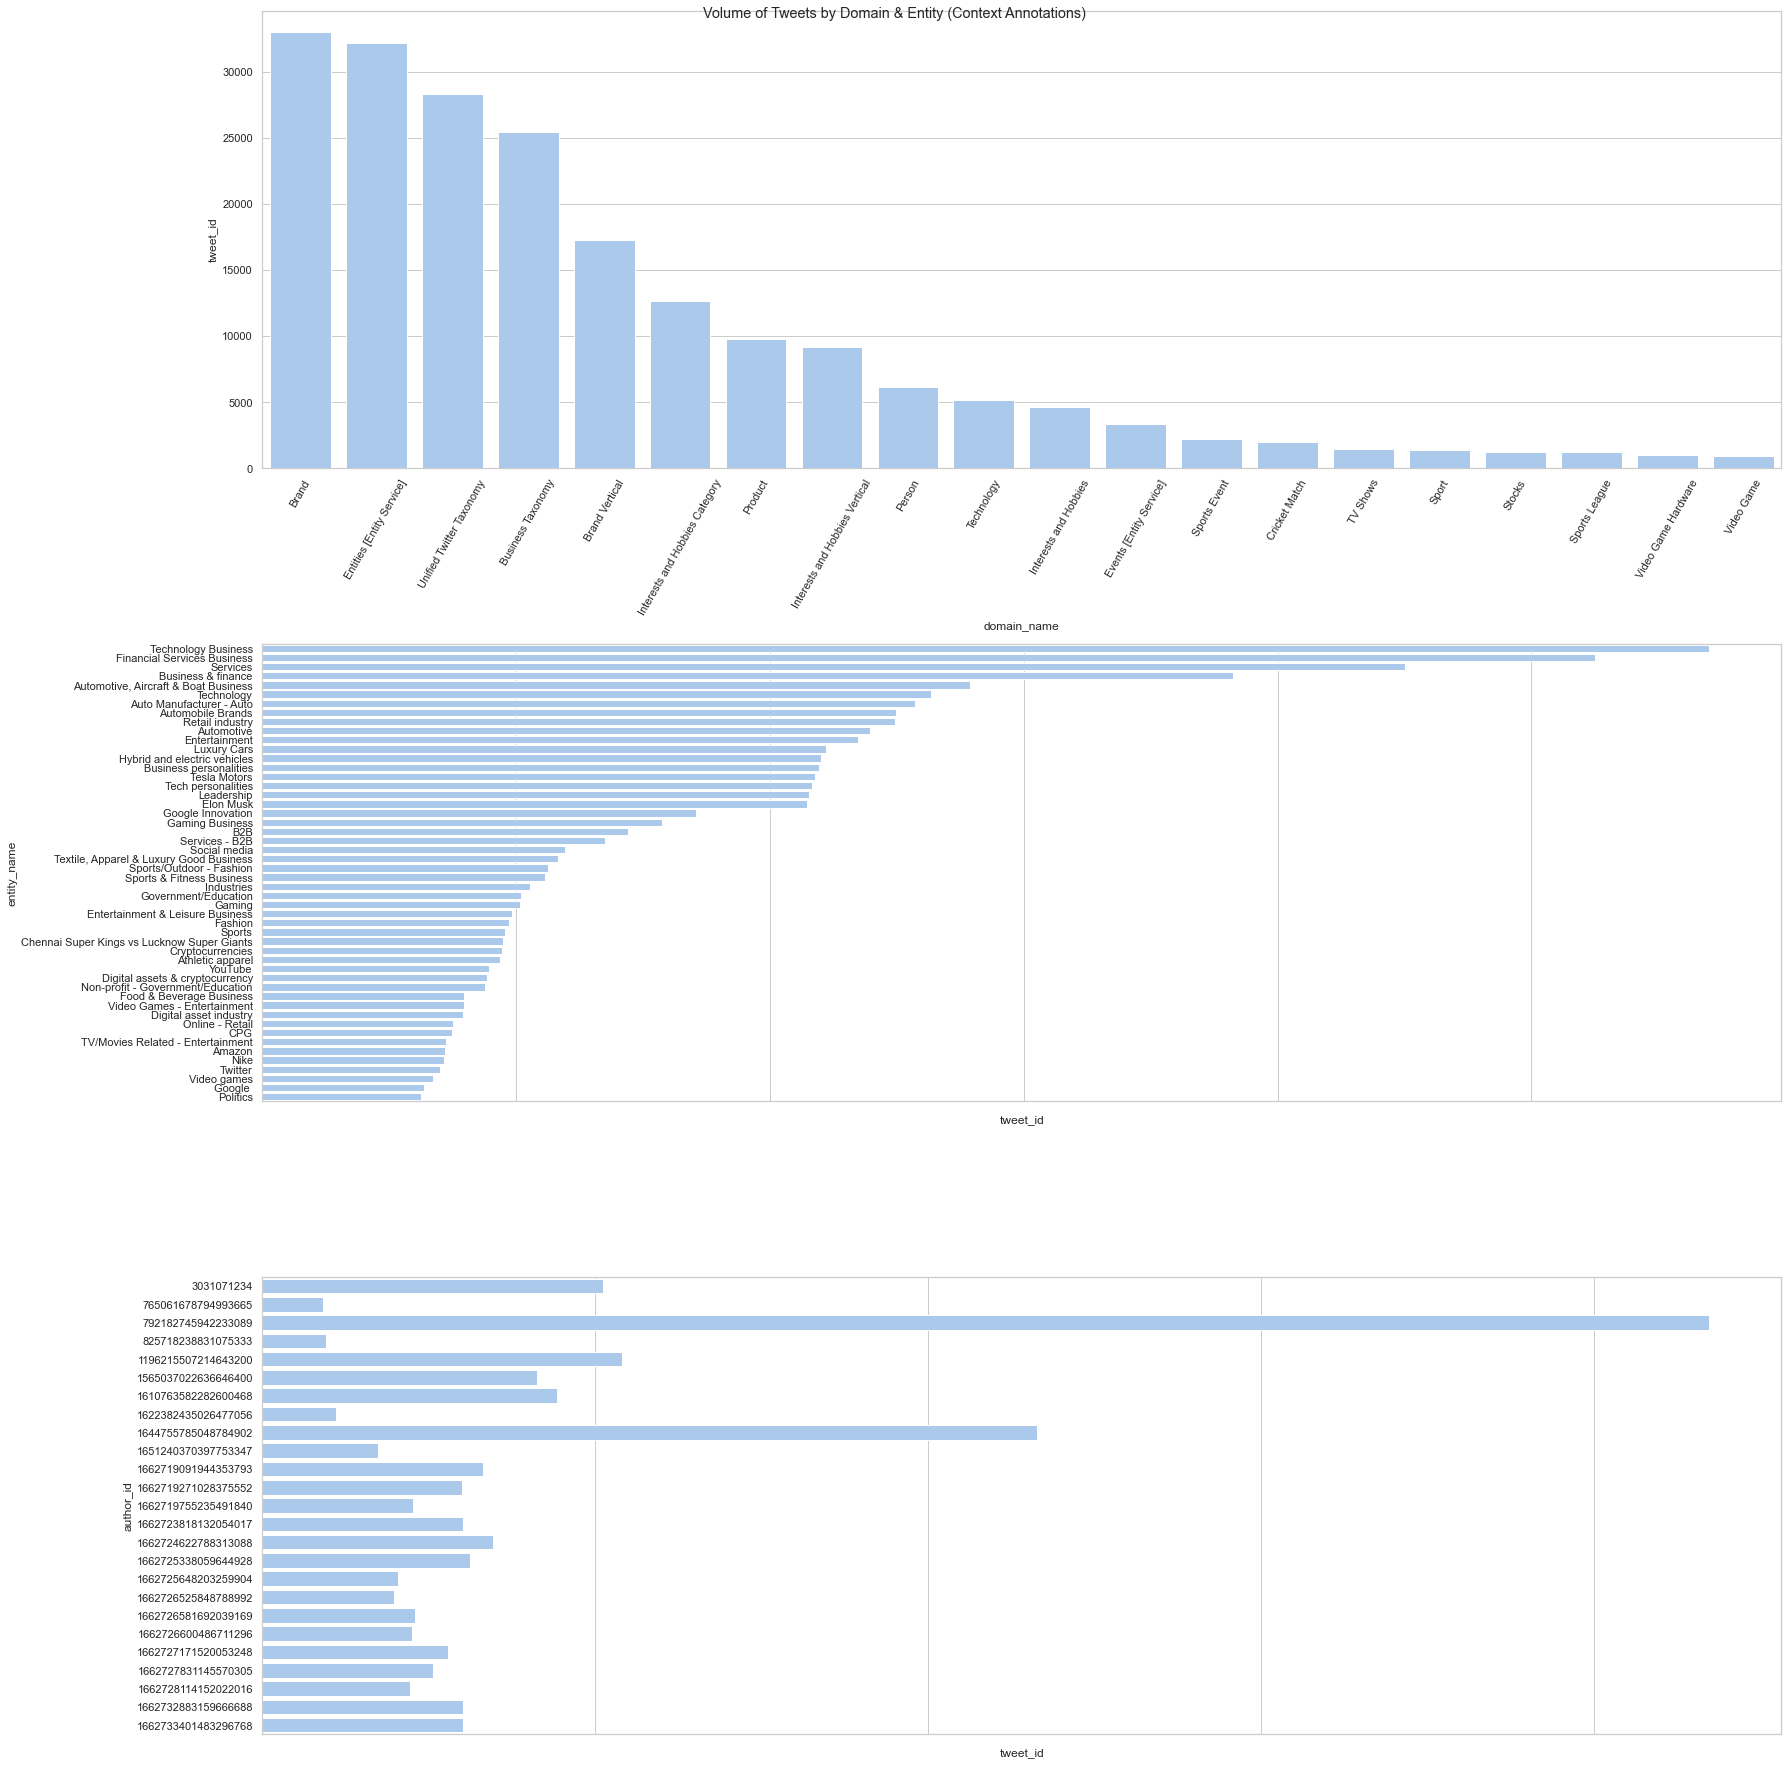

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axs = plt.subplots(3, figsize = (25, 35))
fig.suptitle('Volume of Tweets by Domain & Entity (Context Annotations)')

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(ax=axs[0], x=top_20_domain_counts['domain_name'], y=top_20_domain_counts['tweet_id'], color="b")
sns.barplot(ax=axs[1], x=top_50_entity_counts['tweet_id'], y=top_50_entity_counts['entity_name'], color="b", orient='h')
sns.barplot(ax=axs[2], x=top_25_user_counts['tweet_id'], y=top_25_user_counts['author_id'], color="b", orient='h')


# Rotate the x-axis labels
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=60)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=60)


plt.tight_layout()  # Adjust spacing to avoid label overlap

plt.show()

In [ ]:
##WHAT IS THE DISTRIBUTION OF FOLLOWER COUNT FOR ALL USERS
##WHAT IS THE DISTRIBUTION OF FOLLOWING-FOLLWOING RATION FOR ALL USERS
##DO SOME ANALYSIS USING NTLK ON EACH USER'S BIO 

In [ ]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [ ]:
def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


In [ ]:
import string
import nltk
nltk.download('stopwords')

""" Tokenizes a text to its words, removes and replaces some of them """    
finalTokens = [] # all tokens
stoplist = stopwords.words('english')
my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
allowedWordTypes = ["J","R","V","N"] #  J is Adject, R is Adverb, V is Verb, N is Noun. These are used for POS Tagging

# Create a DataFrame to store the preprocessed text and tweet ID
preprocessed_data = pd.DataFrame(columns=['tweet_id', 'text'])

In [ ]:
def tokenize(text, wordCountBefore, tweet_id):
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = []  # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)  # Technique 7: remove punctuation

    tokens = nltk.word_tokenize(text)

    tagged = nltk.pos_tag(tokens)  # Technique 13: part of speech tagging
    for w in tagged:
        if w[1][0] in allowedWordTypes and w[0] not in stoplist:
            onlyOneSentenceTokens.append(w[0])
            finalTokens.append(w[0])

    onlyOneSentence = " ".join(onlyOneSentenceTokens)

    # Store the preprocessed text and tweet ID in the DataFrame
    preprocessed_data.loc[len(preprocessed_data)] = [tweet_id, onlyOneSentence]

    return finalTokens

In [ ]:
from time import time
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Retrieve all tweets from the database
query = "SELECT DISTINCT * FROM tweets"
df_tweets = pd.read_sql_query(query, conn)
#Tweet_id is column 0, text is column 3


t0 = time()
totalSentences = 0
totalEmoticons = 0
totalSlangs = 0
totalSlangsFound = []
totalElongated = 0
totalMultiExclamationMarks = 0
totalMultiQuestionMarks = 0
totalMultiStopMarks = 0
totalAllCaps = 0

# Iterate over each row in df_tweets
for index, row in df_tweets.iterrows():
    totalSentences += 1
    feat = []

    tweet_id = row['tweet_id']
    text     = removeUnicode(row['text'])  # Technique 0

    wordCountBefore = len(re.findall(r'\w+', text))  # word count of one sentence before preprocess

    emoticons = countEmoticons(text)  # how many emoticons in this sentence
    totalEmoticons += emoticons

    text = removeEmoticons(text)  # removes emoticons from text
    tokens = tokenize(text, wordCountBefore, tweet_id)  

    print("Processed tweet:", tweet_id)  # Print the tweet ID after processing

# View the resulting preprocessed data
print(preprocessed_data.head())
    
print("Total sentences: ",totalSentences,"\n")
print("Total Words before preprocess: ",len(re.findall(r'\w+', df_tweets)))
print("Total Distinct Tokens before preprocess: ",len(set(re.findall(r'\w+', df_tweets))))
print("Average word/sentence before preprocess: ",len(re.findall(r'\w+', df_tweets))/totalSentences,"\n")
print("Total Words after preprocess: ",len(tokens))
print("Total Distinct Tokens after preprocess: ",len(set(tokens)))
print("Average word/sentence after preprocess: ",len(tokens)/totalSentences,"\n")


print("Total run time: ",time() - t0," seconds\n")

print("Total emoticons: ",totalEmoticons,"\n")
print("Total slangs: ",totalSlangs,"\n")
commonSlangs = nltk.FreqDist(totalSlangsFound)
for (word, count) in commonSlangs.most_common(20): # most common slangs across all texts
    print(word,"\t",count)

commonSlangs.plot(20, cumulative=False) # plot most common slangs

print("Total elongated words: ",totalElongated,"\n")
print("Total multi exclamation marks: ",totalMultiExclamationMarks)
print("Total multi question marks: ",totalMultiQuestionMarks)
print("Total multi stop marks: ",totalMultiStopMarks,"\n")
print("Total all capitalized words: ",totalAllCaps,"\n")

#print(tokens)
commonWords = nltk.FreqDist(tokens)
print("Most common words ")
print("Word\tCount")
for (word, count) in commonWords.most_common(100): # most common words across all texts
    print(word,"\t",count)

commonWords.plot(100, cumulative=False) # plot most common words


bgm = nltk.collocations.BigramAssocMeasures()
tgm = nltk.collocations.TrigramAssocMeasures()
bgm_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
tgm_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bgm_finder.apply_freq_filter(5) # bigrams that occur at least 5 times
print("Most common collocations (bigrams)")
print(bgm_finder.nbest(bgm.pmi, 50)) # top 50 bigram collocations
tgm_finder.apply_freq_filter(5) # trigrams that occur at least 5 times
print("Most common collocations (trigrams)")
print(tgm_finder.nbest(tgm.pmi, 20)) # top 20 trigrams collocations